# 3.2.2 Deep analysis of DB_TOTAL_TIME and CPU_TIME

This notebook answers the following questions:

- [X] What is the average DB_TIME of our sample?
- [X] Is there a relationship between the DB_TIME and DB_BLOCKS fields?
- [X] Is there a relationship between the CPU_TIME and ROW_COUNT fields?

In [21]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import HTML

### Aligning data visualizations

The following code is used to center and align the visualizations laid out below.

In [22]:
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""") 

### Loadind Data

In [23]:
source_path_reports = "./datasets/active_reports.csv"


reports = pd.read_csv(source_path_reports)
reports['DB_TOTAL_TIME'] = reports.apply(lambda row: (row['DB_TOTAL_TIME']/1000000), axis=1)

In [24]:
source_path_pg_view = "data/Salesforce/ELF/LightningPageView/2022-06-20_LightningPageView.csv"

page_view = pd.read_csv(source_path_pg_view)

## 1. What is the average DB_TIME of our sample?

Before we start with data manipulation, it is necessary to clarify which are the fields of interest in this analysis:
1. **DB_TOTAL_TIME**: The time in nanoseconds for a database round trip. Includes time spent in the JDBC driver, network to the database, and DB_CPU_TIME. Compare this field to CPU_TIME to determine whether performance issues are occurring in the database layer or in your own code;
2. **DB_CPU_TIME**: The CPU time in milliseconds to complete the request. Indicates the amount of activity taking place in the database layer during the request;
3. **CPU_TIME**: The CPU time in milliseconds used to complete the request. This field indicates the amount of activity taking place in the app server layer;
4. **DB_BLOCKS**: Indicates how much activity is occurring in the database. A high value for this field suggests that adding indexes or filters on your queries would benefit performance;
5. **ROW_COUNT**: The number of rows that were processed in the Report event.

All definitions detailed above can be found in this [reference](https://developer.salesforce.com/docs/atlas.en-us.238.0.object_reference.meta/object_reference/sforce_api_objects_eventlogfile_report.htm). In this analysis, it was decided to define a new metric (**DB_TIME**) to evaluate the average time of the difference between the **DB_TOTAL_TIME** and **CPU_TIME** fields.

### 1.1 Analysis of data skewness and spread

To start exploring the data, the skewness and spread of the fields under analysis are verified via box plots and the [five-number summary](https://en.wikipedia.org/wiki/Five-number_summary). So, the following are boxplots for DB_TOTAL_TIME, CPU_TIME, DB_TIME, and adjusted DB_TIME (with the more pronounced outliers removed).

In [25]:
reports['DB_TIME'] = reports.apply(lambda row: (row['DB_TOTAL_TIME'] - row['CPU_TIME']), axis=1)
reports = reports.sort_values(by=['DB_TIME'], ascending=False)

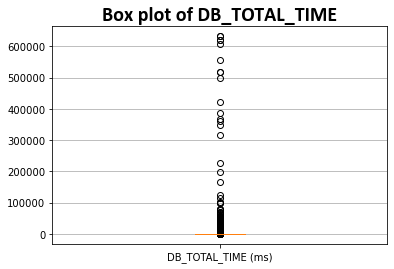

In [26]:
plt.grid(True, axis='y')

plt.boxplot(reports['DB_TOTAL_TIME'], labels = ['DB_TOTAL_TIME (ms)'])
plt.title('Box plot of DB_TOTAL_TIME', fontsize=20, fontweight="bold", fontname="Calibri");

plt.show()

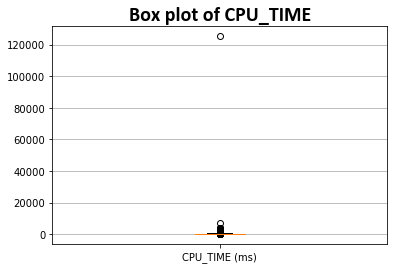

In [27]:
plt.grid(True, axis='y')

plt.boxplot(reports['CPU_TIME'], labels = ['CPU_TIME (ms)'])
plt.title('Box plot of CPU_TIME', fontsize=20, fontweight="bold", fontname="Calibri");

plt.show()

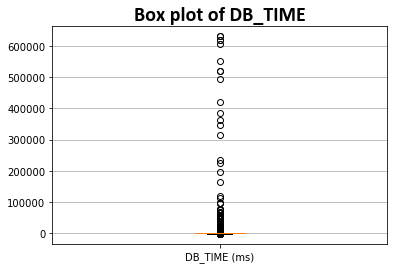

In [28]:
plt.grid(True, axis='y')

plt.boxplot(reports['DB_TIME'], labels = ['DB_TIME (ms)'])
plt.title('Box plot of DB_TIME', fontsize=20, fontweight="bold", fontname="Calibri");

plt.show()

It can be seen from the results of the figures above that three outliers values present in the DB_TOTAL_TIME data cause a great skewness. Therefore, a sample of the data without such values was generated to evaluate the influence on the average values of the fields under analysis. The box plot adjusted for this sample can be seen below:

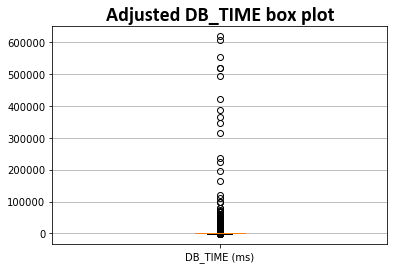

In [29]:
reports_aux = reports.drop(reports.index[:3])

plt.grid(True, axis='y')

plt.boxplot(reports_aux['DB_TIME'], labels = ['DB_TIME (ms)'])
plt.title('Adjusted DB_TIME box plot', fontsize=20, fontweight="bold", fontname="Calibri");

plt.show()

### 1.2 Analysis of DB_TIME values

According to the analysis carried out in [this task](https://github.com/dell-splab/lightning-analysis/blob/main/3.2%20Is%20the%20bottleneck%20in%20the%20application%20level%20.ipynb), it is known that in general the values of DB_TOTAL_TIME are greater than the values of CPU_TIME (time spent on the server is greater than that spent on the application). The following code quantifies how much greater the DB_TOTAL_TIME values are than the CPU_TIME values.

In [30]:
values_greater_zero = reports['DB_TIME'].apply(lambda value: value > 0)
v_counts = values_greater_zero.value_counts()

print(f"Total number of values: {v_counts[1] + v_counts[0]}")
print(f"Values where DB_TOTAL_TIME > CPU_TIME: {v_counts[1]}")

Total number of values: 7101
Values where DB_TOTAL_TIME > CPU_TIME: 1364


- For clarity, below is a pie chart detailing the values.

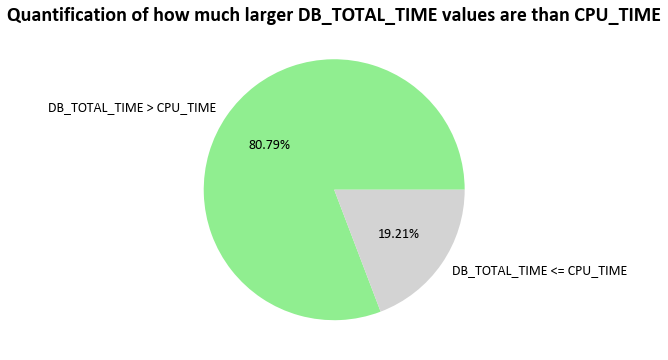

In [31]:
plt.figure(figsize=(6,6))
plt.pie(v_counts, autopct='%1.2f%%', radius=1, 
        labels = ['DB_TOTAL_TIME > CPU_TIME', 'DB_TOTAL_TIME <= CPU_TIME'], 
        textprops = {'size': 14, 'font': 'Calibri'}, colors=['lightgreen' ,'lightgrey'])

plt.title('Quantification of how much larger DB_TOTAL_TIME values are than CPU_TIME', 
          fontsize=20, fontweight="bold", fontname="Calibri");
plt.show() 

### 1.3 DB_TIME by reports data

The following analysis concerns the evaluation of above-average DB_TIME values for the reports file.

In [32]:
dbt_mean1 = reports['DB_TIME'].mean()
dbt_median1 = reports['DB_TIME'].median()

print("Result for original data: ")
print(f"Mean = {dbt_mean1:.2f} miliseconds")
print(f"Median = {dbt_median1:.2f} miliseconds")

Result for original data: 
Mean = 1917.69 miliseconds
Median = -224.98 miliseconds


In [33]:
dbt_mean2 = reports_aux['DB_TIME'].mean()
dbt_median2 = reports_aux['DB_TIME'].median()

print("Result for adjusted data: ")
print(f"Mean = {dbt_mean2:.2f} miliseconds")
print(f"Median = {dbt_median2:.2f} miliseconds")

Result for adjusted data: 
Mean = 1653.54 miliseconds
Median = -225.00 miliseconds


From the above results it is clear that the three outliers removed from the sample cause a large distortion in the data distribution; then, we will continue the analysis with the adjusted sample.

In [34]:
above_mean = reports_aux['DB_TIME'].apply(lambda value: value > dbt_mean2)

- The following pie chart demonstrates that in general the DB_TIME values are higher than the average (57.12%). This fact confirms that the amount of time spent on the server is dominant in relation to the time spent on the application.

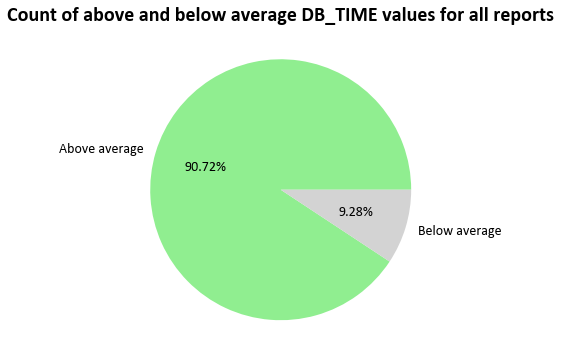

In [35]:
plt.figure(figsize=(6,6))
plt.pie(above_mean.value_counts(), autopct='%1.2f%%', radius=1.0, labels = ['Above average', 'Below average'],  
        textprops = {'size': 14, 'font': 'Calibri'}, colors=['lightgreen' ,'lightgrey'])

plt.title('Count of above and below average DB_TIME values for all reports', fontsize=20, fontweight="bold", fontname="Calibri");
plt.show()

### 1.4 DB_TIME by components

The following analysis concerns the evaluation of above-average DB_TIME values by components (PAGE_CONTEXT field).

In [36]:
page_view = page_view.drop(columns=['EVENT_TYPE',
 'REQUEST_ID',
 'ORGANIZATION_ID',
 'USER_ID',
 'CLIENT_ID',
 'LOGIN_KEY',
 'USER_TYPE',
 'APP_NAME',
 'DEVICE_PLATFORM',
 'SDK_APP_VERSION',
 'OS_NAME',
 'OS_VERSION',
 'USER_AGENT',
 'BROWSER_NAME',
 'BROWSER_VERSION',
 'SDK_VERSION',
 'DEVICE_MODEL',
 'DEVICE_ID',
 'SDK_APP_TYPE',
 'CLIENT_GEO',
 'CONNECTION_TYPE',
 'UI_EVENT_ID',
 'UI_EVENT_SOURCE',
 'UI_EVENT_TIMESTAMP',
 'PAGE_START_TIME',
 'DURATION',
 'EFFECTIVE_PAGE_TIME_DEVIATION',
 'EFFECTIVE_PAGE_TIME_DEVIATION_REASON',
 'EFFECTIVE_PAGE_TIME_DEVIATION_ERROR_TYPE',
 'EFFECTIVE_PAGE_TIME',
 'DEVICE_SESSION_ID',
 'UI_EVENT_SEQUENCE_NUM',
 'PAGE_ENTITY_ID',
 'PAGE_ENTITY_TYPE',
 'PAGE_APP_NAME',
 'PREVPAGE_ENTITY_ID',
 'PREVPAGE_ENTITY_TYPE',
 'PREVPAGE_APP_NAME',
 'TARGET_UI_ELEMENT',
 'PARENT_UI_ELEMENT',
 'GRANDPARENT_UI_ELEMENT',
 'CLIENT_IP'])

In [37]:
run_report_api_resource = "/lightning/r/"

def get_report_info_from_endpoint(page_url):
    if page_url.startswith(run_report_api_resource):
        uri = page_url.split(run_report_api_resource)
        if len(uri) >= 2:
            report_type, report_id_derived = uri[1].split("/")[:2]
            return report_type, report_id_derived

In [39]:
page_view.dropna(subset=['PAGE_URL'], inplace=True)

In [40]:
page_view['REPORT_INFO_DERIVED'] = page_view.PAGE_URL.apply(get_report_info_from_endpoint)

In [41]:
page_view.dropna(subset=['REPORT_INFO_DERIVED'], inplace=True)

In [42]:
page_view['REPORT_TYPE_DERIVED'] = page_view.REPORT_INFO_DERIVED.str[0]
page_view['REPORT_ID_DERIVED'] = page_view.REPORT_INFO_DERIVED.str[1]

In [43]:
page_view.drop(columns='REPORT_INFO_DERIVED')

,TIMESTAMP,SESSION_KEY,PAGE_CONTEXT,PAGE_URL,PREVPAGE_CONTEXT,PREVPAGE_URL,TIMESTAMP_DERIVED,USER_ID_DERIVED,REPORT_TYPE_DERIVED,REPORT_ID_DERIVED
0,2.022062e+13,DkrMLnselIW4a5EP,one:recordHomeFlexipage2Wrapper,/lightning/r/pse__Proj__c/a2U6P000000GybgUAC/view,home:landing,/lightning/page/home,2022-06-20T00:00:03.155Z,0056P000000xXGcQAM,pse__Proj__c,a2U6P000000GybgUAC
2,2.022062e+13,kli/tj2J178nuyC/,one:recordHomeFlexipage2Wrapper,/lightning/r/Case/5006P000005SbYIQA0/view,one:recordHomeFlexipage,/lightning/r/WorkOrder/0WO6P0000022kdHWAQ/view...,2022-06-20T00:00:17.340Z,0050b000004K6qiAAC,Case,5006P000005SbYIQA0
3,2.022062e+13,13BZwFCUcj0WV/FF,one:recordHomeFlexipage2Wrapper,/lightning/r/Case/5006P000005AiInQAK/view?ws=%...,one:recordHomeFlexipage2Wrapper,/lightning/r/Case/5006P000006C7deQAC/view,2022-06-20T00:00:17.592Z,0051P000003jYNOQA2,Case,5006P000005AiInQAK
6,2.022062e+13,RbJWxjOn15YBp1AS,one:recordHomeFlexipage,/lightning/r/WorkOrder/0WO6P000001rxV7WAI/view...,one:recordHomeFlexipage2Wrapper,/lightning/r/Case/5006P000005cq8kQAA/view,2022-06-20T00:00:28.666Z,0052R000009TqFeQAK,WorkOrder,0WO6P000001rxV7WAI
8,2.022062e+13,hXXfG+/yor4lYGG6,one:recordHomeFlexipage2Wrapper,/lightning/r/Case/5006P0000055jyrQAA/view,undefined,NaN,2022-06-20T00:00:33.244Z,0050b000004KRPiAAO,Case,5006P0000055jyrQAA
...,...,...,...,...,...,...,...,...,...,...
9665,2.022062e+13,j6rb3/a2a99Rvenp,one:recordHomeFlexipage2Wrapper,/lightning/r/Case/5006P000005d8lgQAA/view,one:recordHomeFlexipage2Wrapper,/lightning/r/Case/5006P0000064bvmQAA/view,2022-06-20T00:59:58.909Z,0052R00000ASPVKQA5,Case,5006P000005d8lgQAA
9667,2.022062e+13,FFqIXSkd1lg3R12W,reports:reportBase,/lightning/r/Report/00O0b000006iNwdEAE/view?qu...,omni:supervisorPanel,/one/one.app#eyJjb21wb25lbnREZWYiOiJvbW5pOnN1c...,2022-06-20T00:59:59.471Z,0050b000004K6s0AAC,Report,00O0b000006iNwdEAE
9668,2.022062e+13,zSlTWpkr6eIMM1jJ,one:recordHomeFlexipage2Wrapper,/lightning/r/Case/5006P000005WkI7QAK/view,force:objectHomeDesktop,/lightning/o/Case/list?filterName=00B2R000005i...,2022-06-20T00:59:59.475Z,0050b000004KCW0AAO,Case,5006P000005WkI7QAK
9669,2.022062e+13,fpCpwvb6vZPBenEc,one:recordHomeFlexipage2Wrapper,/lightning/r/Contact/0036P000004JSl5QAG/view?w...,one:recordHomeFlexipage2Wrapper,/lightning/r/Case/5006P000005cMpfQAE/view,2022-06-20T00:59:59.627Z,0050b000004KDXgAAO,Contact,0036P000004JSl5QAG


In [44]:
merged_data = pd.merge(
left=reports_aux,
right=page_view,
on='REPORT_ID_DERIVED')

In [45]:
merged_data 

,CreatedById,CreatedDate,Description,DeveloperName,FolderName,Format,Id,IsDeleted,LastModifiedById,LastModifiedDate,...,TIMESTAMP_y,SESSION_KEY_y,PAGE_CONTEXT,PAGE_URL,PREVPAGE_CONTEXT,PREVPAGE_URL,TIMESTAMP_DERIVED_y,USER_ID_DERIVED_y,REPORT_INFO_DERIVED,REPORT_TYPE_DERIVED
0,0050b000004MLUiAAO,2021-08-06T00:31:16.000Z,NaN,B2C_APJ_OOW_Work_orders_4i2,WorkOrder reports,Tabular,00O2R000003JUDGUA4,False,0050b000004JzRCAA0,2022-06-13T09:18:29.000,...,2.022062e+13,B4+mChe1wAdhXrmd,reports:reportBase,/lightning/r/Report/00O2R000003JUDGUA4/view?qu...,forceSearch:searchPageDesktop,/one/one.app#eyJjb21wb25lbnREZWYiOiJmb3JjZVNlY...,2022-06-20T00:37:48.620Z,0050b000004KWbZAAW,"(Report, 00O2R000003JUDGUA4)",Report
1,0050b000004MLUiAAO,2021-08-06T00:31:16.000Z,NaN,B2C_APJ_OOW_Work_orders_4i2,WorkOrder reports,Tabular,00O2R000003JUDGUA4,False,0050b000004JzRCAA0,2022-06-13T09:18:29.000,...,2.022062e+13,X3C8ufGngehfcAAC,reports:reportBase,/lightning/r/Report/00O2R000003JUDGUA4/view?qu...,one:recordHomeFlexipage,/lightning/r/WorkOrder/0WO6P000001s243WAA/view...,2022-06-20T00:42:39.675Z,0050b000004KT0NAAW,"(Report, 00O2R000003JUDGUA4)",Report
2,0050b000004MLUiAAO,2021-08-06T00:31:16.000Z,NaN,B2C_APJ_OOW_Work_orders_4i2,WorkOrder reports,Tabular,00O2R000003JUDGUA4,False,0050b000004JzRCAA0,2022-06-13T09:18:29.000,...,2.022062e+13,B4+mChe1wAdhXrmd,reports:reportBase,/lightning/r/Report/00O2R000003JUDGUA4/view?qu...,forceSearch:searchPageDesktop,/one/one.app#eyJjb21wb25lbnREZWYiOiJmb3JjZVNlY...,2022-06-20T00:37:48.620Z,0050b000004KWbZAAW,"(Report, 00O2R000003JUDGUA4)",Report
3,0050b000004MLUiAAO,2021-08-06T00:31:16.000Z,NaN,B2C_APJ_OOW_Work_orders_4i2,WorkOrder reports,Tabular,00O2R000003JUDGUA4,False,0050b000004JzRCAA0,2022-06-13T09:18:29.000,...,2.022062e+13,X3C8ufGngehfcAAC,reports:reportBase,/lightning/r/Report/00O2R000003JUDGUA4/view?qu...,one:recordHomeFlexipage,/lightning/r/WorkOrder/0WO6P000001s243WAA/view...,2022-06-20T00:42:39.675Z,0050b000004KT0NAAW,"(Report, 00O2R000003JUDGUA4)",Report
4,0050b000004MLUiAAO,2021-08-06T00:31:16.000Z,NaN,B2C_APJ_OOW_Work_orders_4i2,WorkOrder reports,Tabular,00O2R000003JUDGUA4,False,0050b000004JzRCAA0,2022-06-13T09:18:29.000,...,2.022062e+13,B4+mChe1wAdhXrmd,reports:reportBase,/lightning/r/Report/00O2R000003JUDGUA4/view?qu...,forceSearch:searchPageDesktop,/one/one.app#eyJjb21wb25lbnREZWYiOiJmb3JjZVNlY...,2022-06-20T00:37:48.620Z,0050b000004KWbZAAW,"(Report, 00O2R000003JUDGUA4)",Report
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556841,0050b000004K7haAAC,2021-08-27T01:40:58.000Z,NaN,Order_Checking_New1,Qiuling,Summary,00O2R000003zZykUAE,False,0050b000004K7haAAC,2022-05-30T10:01:51.000,...,2.022062e+13,FNH74b+aOHHTTV/y,reports:reportBase,/lightning/r/Report/00O2R000003zZykUAE/view,undefined,NaN,2022-06-20T00:27:38.944Z,0056P000000xYNpQAM,"(Report, 00O2R000003zZykUAE)",Report
556842,0050b000004K7haAAC,2021-08-27T01:40:58.000Z,NaN,Order_Checking_New1,Qiuling,Summary,00O2R000003zZykUAE,False,0050b000004K7haAAC,2022-05-30T10:01:51.000,...,2.022062e+13,FNH74b+aOHHTTV/y,reports:reportBase,/lightning/r/Report/00O2R000003zZykUAE/view,undefined,NaN,2022-06-20T00:27:38.944Z,0056P000000xYNpQAM,"(Report, 00O2R000003zZykUAE)",Report
556843,0050b000004K7haAAC,2021-08-27T01:40:58.000Z,NaN,Order_Checking_New1,Qiuling,Summary,00O2R000003zZykUAE,False,0050b000004K7haAAC,2022-05-30T10:01:51.000,...,2.022062e+13,FNH74b+aOHHTTV/y,reports:reportBase,/lightning/r/Report/00O2R000003zZykUAE/view,undefined,NaN,2022-06-20T00:27:38.944Z,0056P000000xYNpQAM,"(Report, 00O2R000003zZykUAE)",Report
556844,0050b000004K7haAAC,2021-08-27T01:40:58.000Z,NaN,Order_Checking_New1,Qiuling,Summary,00O2R000003zZykUAE,False,0050b000004K7haAAC,2022-05-30T10:01:51.000,...,2.022062e+13,FNH74b+aOHHTTV/y,reports:reportBase,/lightning/r/Report/00O2R000003zZykUAE/view,undefined,NaN,2022-06-20T00:27:38.944Z,0056P000000xYNpQAM,"(Report, 00O2R000003zZykUAE)",Report


In [46]:
dbt_mean = merged_data['DB_TIME'].mean()
dbt_median = merged_data['DB_TIME'].median()

print(f"Mean = {dbt_mean:.2f} miliseconds")
print(f"Median = {dbt_median:.2f} miliseconds")

Mean = -129.40 miliseconds
Median = -233.84 miliseconds


- The result of the following pie chart, considering DB_TIME by component, aligns with the previous result: in general DB_TIME values are considerably higher than the average (84.49%).

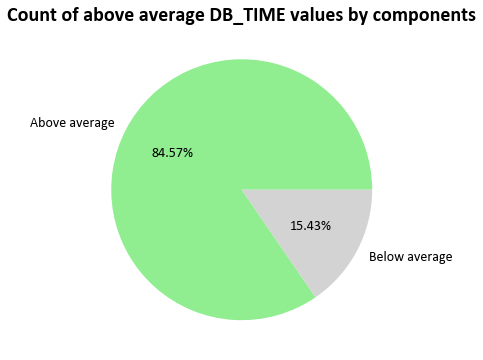

In [47]:
above_mean = merged_data['DB_TIME'].apply(lambda value: value > dbt_mean)

plt.figure(figsize=(6,6))

plt.title('Count of above average DB_TIME values by components', fontsize=20, fontweight="bold", fontname="Calibri");
plt.pie(above_mean.value_counts(), autopct='%1.2f%%', labels = ['Above average', 'Below average'],
         textprops = {'size': 14, 'font': 'Calibri'}, colors=['lightgreen' ,'lightgrey'])

plt.show()

In [48]:
above_mean_values = merged_data[merged_data.DB_TOTAL_TIME > dbt_mean]

amount_data = 10

data_dict = above_mean_values.groupby("PAGE_CONTEXT")['DB_TIME'].sum()
 
sorted_data_dict = {k: v for k, v in sorted(data_dict.items(), key=lambda item: item[1], reverse = True)}

y_axis = [ pg_context for pg_context in list(sorted_data_dict.keys())[:amount_data] ]

x_axis = list(sorted_data_dict.values())[:amount_data]

In [49]:
df = pd.DataFrame ({
        'pg_context': y_axis,
        'db_t': x_axis
})

df = df.sort_values(by=['db_t'])

- The following bar chart reports the components with the highest DB_TIME values among the above-average filtered values.

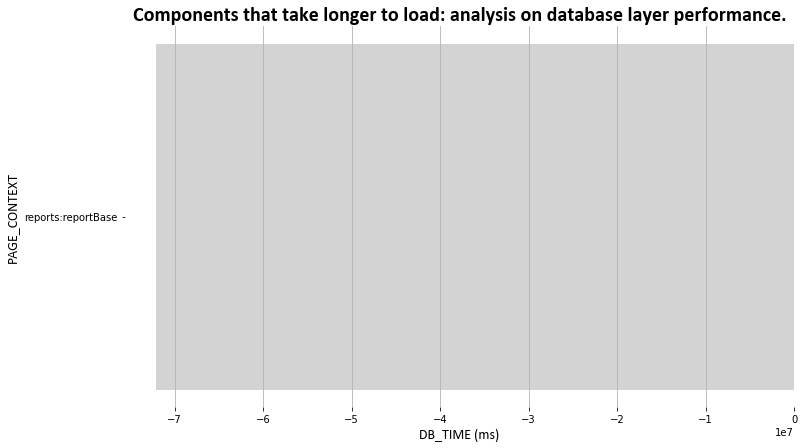

In [50]:

plt.figure(figsize=(12,7))

plt.grid(True, axis='x')

plt.barh(y=df.pg_context, width=df.db_t, color=['lightgrey', 'lightgreen']);

plt.xlabel('DB_TIME (ms)', fontsize=14, fontname="Calibri")
plt.ylabel('PAGE_CONTEXT', fontsize=14, fontname="Calibri")
plt.title('Components that take longer to load: analysis on database layer performance.', fontsize=20, fontweight="bold", fontname="Calibri");

plt.rc('axes', axisbelow=True)
plt.box(on=None)

plt.show()

## 2. Is there a relationship between the DB_TIME and DB_BLOCKS fields?

Next, an analysis of the DB_BLOCKS field is performed to quantify how much activity is occurring in the database by components.

In [58]:
merged_data

,CreatedById,CreatedDate,Description,DeveloperName,FolderName,Format,Id,IsDeleted,LastModifiedById,LastModifiedDate,...,TIMESTAMP_y,SESSION_KEY_y,PAGE_CONTEXT,PAGE_URL,PREVPAGE_CONTEXT,PREVPAGE_URL,TIMESTAMP_DERIVED_y,USER_ID_DERIVED_y,REPORT_INFO_DERIVED,REPORT_TYPE_DERIVED
0,0050b000004MLUiAAO,2021-08-06T00:31:16.000Z,NaN,B2C_APJ_OOW_Work_orders_4i2,WorkOrder reports,Tabular,00O2R000003JUDGUA4,False,0050b000004JzRCAA0,2022-06-13T09:18:29.000,...,2.022062e+13,B4+mChe1wAdhXrmd,reports:reportBase,/lightning/r/Report/00O2R000003JUDGUA4/view?qu...,forceSearch:searchPageDesktop,/one/one.app#eyJjb21wb25lbnREZWYiOiJmb3JjZVNlY...,2022-06-20T00:37:48.620Z,0050b000004KWbZAAW,"(Report, 00O2R000003JUDGUA4)",Report
1,0050b000004MLUiAAO,2021-08-06T00:31:16.000Z,NaN,B2C_APJ_OOW_Work_orders_4i2,WorkOrder reports,Tabular,00O2R000003JUDGUA4,False,0050b000004JzRCAA0,2022-06-13T09:18:29.000,...,2.022062e+13,X3C8ufGngehfcAAC,reports:reportBase,/lightning/r/Report/00O2R000003JUDGUA4/view?qu...,one:recordHomeFlexipage,/lightning/r/WorkOrder/0WO6P000001s243WAA/view...,2022-06-20T00:42:39.675Z,0050b000004KT0NAAW,"(Report, 00O2R000003JUDGUA4)",Report
2,0050b000004MLUiAAO,2021-08-06T00:31:16.000Z,NaN,B2C_APJ_OOW_Work_orders_4i2,WorkOrder reports,Tabular,00O2R000003JUDGUA4,False,0050b000004JzRCAA0,2022-06-13T09:18:29.000,...,2.022062e+13,B4+mChe1wAdhXrmd,reports:reportBase,/lightning/r/Report/00O2R000003JUDGUA4/view?qu...,forceSearch:searchPageDesktop,/one/one.app#eyJjb21wb25lbnREZWYiOiJmb3JjZVNlY...,2022-06-20T00:37:48.620Z,0050b000004KWbZAAW,"(Report, 00O2R000003JUDGUA4)",Report
3,0050b000004MLUiAAO,2021-08-06T00:31:16.000Z,NaN,B2C_APJ_OOW_Work_orders_4i2,WorkOrder reports,Tabular,00O2R000003JUDGUA4,False,0050b000004JzRCAA0,2022-06-13T09:18:29.000,...,2.022062e+13,X3C8ufGngehfcAAC,reports:reportBase,/lightning/r/Report/00O2R000003JUDGUA4/view?qu...,one:recordHomeFlexipage,/lightning/r/WorkOrder/0WO6P000001s243WAA/view...,2022-06-20T00:42:39.675Z,0050b000004KT0NAAW,"(Report, 00O2R000003JUDGUA4)",Report
4,0050b000004MLUiAAO,2021-08-06T00:31:16.000Z,NaN,B2C_APJ_OOW_Work_orders_4i2,WorkOrder reports,Tabular,00O2R000003JUDGUA4,False,0050b000004JzRCAA0,2022-06-13T09:18:29.000,...,2.022062e+13,B4+mChe1wAdhXrmd,reports:reportBase,/lightning/r/Report/00O2R000003JUDGUA4/view?qu...,forceSearch:searchPageDesktop,/one/one.app#eyJjb21wb25lbnREZWYiOiJmb3JjZVNlY...,2022-06-20T00:37:48.620Z,0050b000004KWbZAAW,"(Report, 00O2R000003JUDGUA4)",Report
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556841,0050b000004K7haAAC,2021-08-27T01:40:58.000Z,NaN,Order_Checking_New1,Qiuling,Summary,00O2R000003zZykUAE,False,0050b000004K7haAAC,2022-05-30T10:01:51.000,...,2.022062e+13,FNH74b+aOHHTTV/y,reports:reportBase,/lightning/r/Report/00O2R000003zZykUAE/view,undefined,NaN,2022-06-20T00:27:38.944Z,0056P000000xYNpQAM,"(Report, 00O2R000003zZykUAE)",Report
556842,0050b000004K7haAAC,2021-08-27T01:40:58.000Z,NaN,Order_Checking_New1,Qiuling,Summary,00O2R000003zZykUAE,False,0050b000004K7haAAC,2022-05-30T10:01:51.000,...,2.022062e+13,FNH74b+aOHHTTV/y,reports:reportBase,/lightning/r/Report/00O2R000003zZykUAE/view,undefined,NaN,2022-06-20T00:27:38.944Z,0056P000000xYNpQAM,"(Report, 00O2R000003zZykUAE)",Report
556843,0050b000004K7haAAC,2021-08-27T01:40:58.000Z,NaN,Order_Checking_New1,Qiuling,Summary,00O2R000003zZykUAE,False,0050b000004K7haAAC,2022-05-30T10:01:51.000,...,2.022062e+13,FNH74b+aOHHTTV/y,reports:reportBase,/lightning/r/Report/00O2R000003zZykUAE/view,undefined,NaN,2022-06-20T00:27:38.944Z,0056P000000xYNpQAM,"(Report, 00O2R000003zZykUAE)",Report
556844,0050b000004K7haAAC,2021-08-27T01:40:58.000Z,NaN,Order_Checking_New1,Qiuling,Summary,00O2R000003zZykUAE,False,0050b000004K7haAAC,2022-05-30T10:01:51.000,...,2.022062e+13,FNH74b+aOHHTTV/y,reports:reportBase,/lightning/r/Report/00O2R000003zZykUAE/view,undefined,NaN,2022-06-20T00:27:38.944Z,0056P000000xYNpQAM,"(Report, 00O2R000003zZykUAE)",Report


In [51]:
amount_data = 10

data_dict = merged_data.groupby("PAGE_CONTEXT")['DB_BLOCKS'].sum()
 
sorted_data_dict = {k: v for k, v in sorted(data_dict.items(), key=lambda item: item[1], reverse = True)}

y_axis = [ pg_context for pg_context in list(sorted_data_dict.keys())[:amount_data] ]

x_axis = list(sorted_data_dict.values())[:amount_data]

In [52]:
df = pd.DataFrame ({
        'pg_context': y_axis,
        'db_b': x_axis
})

df = df.sort_values(by=['db_b'])

- The following view indicates a clear relationship between DB_BLOCKS and DB_TIME. This fact is in line with the results obtained from the correlation matrix generated in [this task](https://github.com/dell-splab/lightning-analysis/blob/main/3.2%20Is%20the%20bottleneck%20in%20the%20application%20level%20.ipynb) (which demonstrates a high correlation between the DB_BLOCKS and DB_CPU_TIME fields). Since DB_TOTAL_TIME is dependent on DB_CPU_TIME, it makes sense for the DB_BLOCKS field to influence DB_TOTAL_TIME.
- The following visualization highlights that among the ten components that take longer to load (highlighted in the previous bar chart), eight are present in this visualization. Therefore, as suggested by the documentation, adding indexes or filters on these queries would benefit performance.

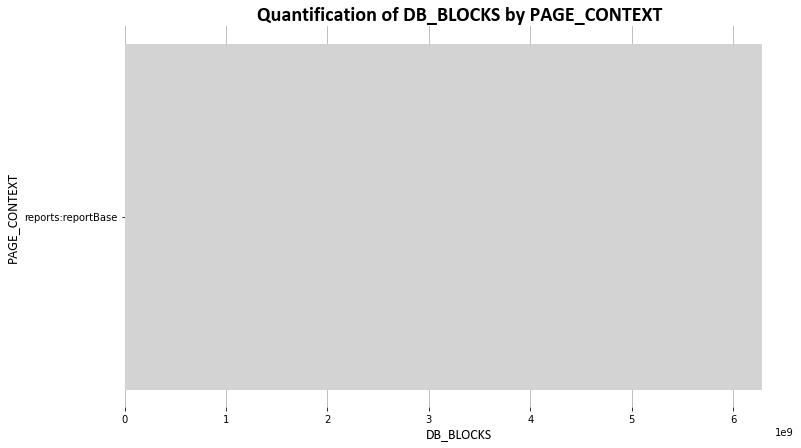

In [53]:
plt.figure(figsize=(12,7))

plt.barh(y=df.pg_context, width=df.db_b, color=['lightgrey', 'lightgreen']);

plt.xlabel('DB_BLOCKS', fontsize=14, fontname="Calibri")
plt.ylabel('PAGE_CONTEXT', fontsize=14, fontname="Calibri")
plt.grid(True, axis='x')
plt.title('Quantification of DB_BLOCKS by PAGE_CONTEXT', fontsize=20, fontweight="bold", fontname="Calibri");

plt.rc('axes', axisbelow=True)
plt.box(on=None)

plt.show()

## 3. Is there a relationship between the CPU_TIME and ROW_COUNT fields?

Below is an analysis to assess whether there is a relationship between CPU_TIME and ROW_COUNT by components. For this, bar charts are used, which relate the ten components with the highest values for each field under analysis.

In [54]:
data_dict = merged_data.groupby("PAGE_CONTEXT")['CPU_TIME'].sum()
 
sorted_data_dict = {k: v for k, v in sorted(data_dict.items(), key=lambda item: item[1], reverse = True)}

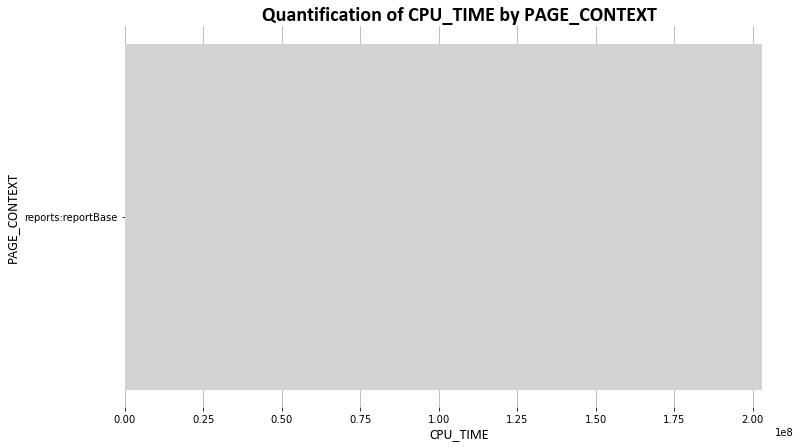

In [55]:
plt.figure(figsize=(12,7))

amount_data = 10

y_axis = list(sorted_data_dict.keys())[:amount_data];
x_axis = list(sorted_data_dict.values())[:amount_data]


plt.barh(y = y_axis, width = x_axis, color=['lightgrey', 'lightgreen'])
plt.gca().invert_yaxis();
plt.xlabel('CPU_TIME', fontsize=14, fontname="Calibri")
plt.ylabel('PAGE_CONTEXT', fontsize=14, fontname="Calibri")
plt.grid(True, axis='x')
plt.title('Quantification of CPU_TIME by PAGE_CONTEXT', fontsize=20, fontweight="bold", fontname="Calibri");

plt.rc('axes', axisbelow=True)
plt.box(on=None)

plt.show()

In [56]:
data_dict = merged_data.groupby("PAGE_CONTEXT")['ROW_COUNT'].sum()
 
sorted_data_dict = {k: v for k, v in sorted(data_dict.items(), key=lambda item: item[1], reverse = True)}

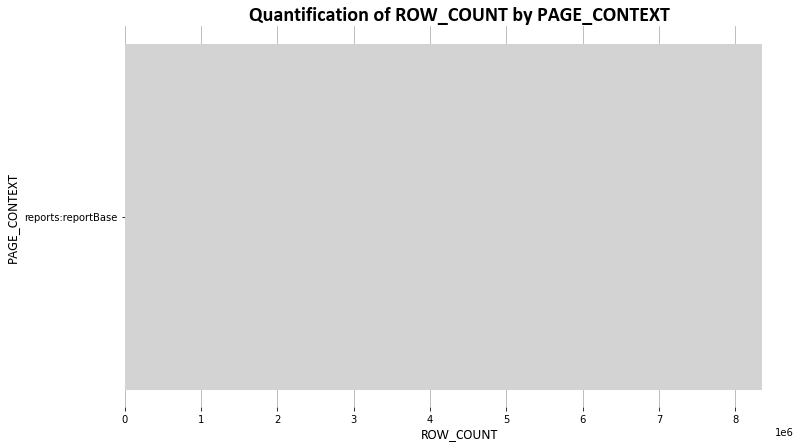

In [57]:
plt.figure(figsize=(12,7))

amount_data = 10

y_axis = list(sorted_data_dict.keys())[:amount_data];
x_axis = list(sorted_data_dict.values())[:amount_data]


plt.barh(y = y_axis, width = x_axis, color=['lightgrey', 'lightgreen'])
plt.gca().invert_yaxis();
plt.xlabel('ROW_COUNT', fontsize=14, fontname="Calibri")
plt.ylabel('PAGE_CONTEXT', fontsize=14, fontname="Calibri")
plt.grid(True, axis='x')
plt.title('Quantification of ROW_COUNT by PAGE_CONTEXT', fontsize=20, fontweight="bold", fontname="Calibri");

plt.rc('axes', axisbelow=True)
plt.box(on=None)

plt.show()

From the visualizations above, it can be seen that out of ten values present in the first chart, nine are present in the second. In view of this fact, a considerable correlation is observed between the CPU_TIME and ROW_COUNT fields, which once again confirms the results obtained in [this task](https://github.com/dell-splab/lightning-analysis/blob/main/3.2%20Is%20the%20bottleneck%20in%20the%20application%20level%20.ipynb).